## 安裝Fuzzy package

In [689]:
# !pip install scikit-fuzzy

## 建立 Fuzzy Set 及設定數值範圍 

## import packages

In [690]:
# import the package
## fuzzy control
import skfuzzy as fuzz
import skfuzzy.control as fuzz_ctrl

import numpy as np
## plot the schematic
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Membership functions

### Universe of discourse
指一個變量的可能值的整個範圍，這些值可以被表示為模糊集合。語境空間可以被視為變量的輸入和輸出範圍，可以根據系統需求進行定義和設置。

例如，假設我們正在設計一個模糊控制器來控制空調系統的溫度。在這種情況下，我們可以定義一個溫度語境空間，表示可能的溫度值的整個範圍，例如15度到35度之間。然後，我們可以在這個範圍內定義一個或多個模糊集合，來描述溫度的變化趨勢，例如“低溫”，“中溫”和“高溫”。

#### 題目要求：溫度=[5，40]℃，濕度=[20，90]％，運行時間=[0，10]分鐘

In [691]:
# Range

## range of temp. & humi & running 
### 建立membership function 的全域範圍，下面numpy只是一個範圍還沒真正定義出模糊的區間
x_temp_range = np.arange(5,41,1,np.float32)
x_humi_range = np.arange(20,91,1,np.float32)
y_time_range = np.arange(0,11,1,np.float32)
##　variable and membership functions
### 建立三個模糊區間：temp(input), humi(input), time(output)
'''
class Antecedent(
    universe: Any,
    label: str
)
'''
x_temp = fuzz_ctrl.Antecedent(x_temp_range, "temp")
x_humi = fuzz_ctrl.Antecedent(x_humi_range, "humi")

'''
class Consequent(
    universe: NDArray[float32],
    label: str,
    defuzzify_method: str = 'centroid'
)
'''
y_time = fuzz_ctrl.Consequent(y_time_range, "time")
## 質心模糊
y_time.defuzzify_method = "centroid" # 預設就是COG



### Scope/Domain

In [692]:
# fuzz.trimf通常用於定義具有三角形形狀的模糊集合
# fuzzy.trapmf通常用於定義具有梯形形狀的模糊集合

## temp 定義5個fuzzy set (input1)
x_temp["cold"] = fuzz.trapmf(x_temp_range,[5,5,10,15])
x_temp["cool"] = fuzz.trimf(x_temp_range,[10,17,20])
x_temp["normal"] = fuzz.trimf(x_temp_range,[14,21,25])
x_temp["warm"] = fuzz.trimf(x_temp_range,[22,30,35])
x_temp["hot"] = fuzz.trapmf(x_temp_range,[28,36,40,40])

## humi 定義3個fuzzy set (input2)
x_humi["dry"] = fuzz.trapmf(x_humi_range,[20,20,35,50])
x_humi["moist"] = fuzz.trapmf(x_humi_range,[40,60,70,75])
x_humi["wet"] = fuzz.trapmf(x_humi_range,[68,85,90,90])

## time 定義3個fuzzy set (output)
y_time["short"] = fuzz.trapmf(y_time_range,[0,0,2,3])
y_time["medium"] = fuzz.trapmf(y_time_range,[2,3,4,7])
y_time["long"] = fuzz.trapmf(y_time_range,[6,8,10,10])



### Rules
|        | Hot      | Warm     | Normal   | Cool     | Cold     |
|--------|----------|----------|----------|----------|----------|
| Dry    | long     | medium   | medium   | short    | short    |
| Moist  | long     | long     | medium   | short    | short    |
| Wet    | long     | long     | long     | medium   | medium   |


In [693]:
# 輸出規則 (根據上表)
rule_long = fuzz_ctrl.Rule(
    antecedent=((x_temp["hot"] & x_humi["dry"]) | (x_temp["hot"] & x_humi["moist"]) | (x_temp["warm"] & x_humi["moist"]) | 
                (x_temp["hot"] & x_humi["wet"]) | (x_temp["warm"] & x_humi["wet"])) | (x_temp["normal"] & x_humi["wet"]), 
                consequent=y_time["long"], label="long")

rule_med = fuzz_ctrl.Rule(
    antecedent=((x_temp["warm"] & x_humi["dry"]) | 
                (x_temp["normal"] & x_humi["dry"]) | (x_temp["normal"] & x_humi["moist"]) | 
                (x_temp["cool"] & x_humi["wet"])) | (x_temp["cold"] & x_humi["wet"]) ,
                consequent=y_time["medium"], label="medium")

rule_short = fuzz_ctrl.Rule(
    antecedent=((x_temp["cool"] & x_humi["moist"]) | (x_temp["cold"] & x_humi["moist"]) | 
                (x_temp['cold'] & x_humi['dry']) | (x_temp["cool"] & x_humi["dry"])), 
                consequent=y_time["short"], label="short")


In [694]:
# 根據前面的規則建立此系統，可以視為建立起整個函數
system = fuzz_ctrl.ControlSystem(rules=[rule_long,rule_med,rule_short])
# 根據建立起來的membership function（system）去模擬
sys_sim = fuzz_ctrl.ControlSystemSimulation(system)


In [695]:
# def fuzzy operation 
def fuzzy(temp, humi):
    # 將數值送入模擬器（根據一開始建立大label)
    sys_sim.input["temp"] = temp
    sys_sim.input["humi"] = humi

    # system compute
    sys_sim.compute()
    out = sys_sim.output["time"]
    print("When {:.2f}℃(Air temperature) and {:.2f}%(humi), Duration Time is {:.2f} min.".format(input_temp, input_humi, out))
    return out


## 使用者輸入

### 這邊做個測試看溫度的下降變化

In [696]:
# 自訂輸入條件 Crisp input
input_temp = int(input("請輸入溫度(℃)"))
input_humi = int(input("請輸入濕度(%)"))
ideal_temp = 25 # 設定理想溫度：25℃
ideal_humi = 35 # 設定理想濕度：35%

In [697]:
# 假設：每過一分鐘，溫度下降0.5℃ 直到小於理想溫度
# 假設：每過一分鐘，濕度下降0.1%
temp_record = []
humi_record = []
time_record = []

for i in range(20):
    error_temp = input_temp - ideal_temp
    error_humi = input_humi - ideal_humi
    temp_record.append(input_temp)
    humi_record.append(input_humi)
    if error_temp > 0:
        running_time = fuzzy(error_temp, input_humi)
        input_temp = input_temp - running_time * 0.5
        input_humi = input_humi - running_time * 0.1
    time_record.append(running_time)



When 57.00℃(Air temperature) and 77.00%(humi), Duration Time is 8.25 min.
When 52.87℃(Air temperature) and 76.17%(humi), Duration Time is 8.23 min.
When 48.76℃(Air temperature) and 75.35%(humi), Duration Time is 8.15 min.
When 44.68℃(Air temperature) and 74.54%(humi), Duration Time is 6.63 min.
When 41.37℃(Air temperature) and 73.87%(humi), Duration Time is 5.30 min.
When 38.72℃(Air temperature) and 73.34%(humi), Duration Time is 3.23 min.
When 37.11℃(Air temperature) and 73.02%(humi), Duration Time is 3.05 min.
When 35.58℃(Air temperature) and 72.72%(humi), Duration Time is 2.89 min.
When 34.14℃(Air temperature) and 72.43%(humi), Duration Time is 2.75 min.
When 32.76℃(Air temperature) and 72.15%(humi), Duration Time is 2.63 min.
When 31.45℃(Air temperature) and 71.89%(humi), Duration Time is 2.52 min.
When 30.19℃(Air temperature) and 71.64%(humi), Duration Time is 2.42 min.
When 28.98℃(Air temperature) and 71.40%(humi), Duration Time is 2.33 min.
When 27.82℃(Air temperature) and 71.16

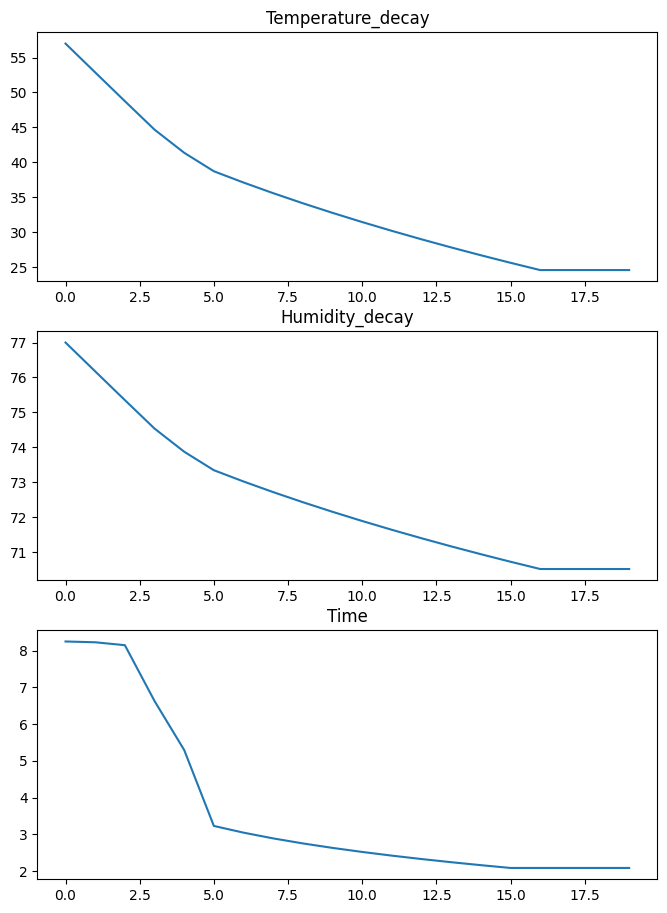

In [698]:
fig,(figure1,figure2,figure3)=plt.subplots(nrows=3,figsize=(8,11))
figure1.plot(range(0,20,1),temp_record)
figure1.set_title("Temperature_decay")
figure2.plot(range(0,20,1),humi_record)
figure2.set_title("Humidity_decay")
figure3.plot(range(0,20,1),time_record)
figure3.set_title("Time")

plt.show()

### 這邊跟hw02一樣基本測試

In [699]:
input_temp = 33
input_humi = 72
out_y = fuzzy(input_temp, input_humi)

When 33.00℃(Air temperature) and 72.00%(humi), Duration Time is 8.28 min.


## Membership Grage

In [700]:
# Setup the dic. to save the label and the grade.
temp_membership_grade = {}
humi_membership_grade = {}

print("Membership Grade:")
print("-"*100)
for key in x_temp.terms: # x_temp.terms 是存放label的一個OrderedDict
    grade = fuzz.interp_membership(x_temp_range, x_temp[key].mf, input_temp) # To get the grade
    temp_membership_grade[key] = grade
    print(f"{key}:{grade:.2f}", end='\t')
print('')
print("-"*100)
for key in x_humi.terms:
    grade = fuzz.interp_membership(x_humi_range, x_humi[key].mf, input_humi)
    humi_membership_grade[key] = grade
    print(f"{key}:{grade:.2f}", end='\t')
print('')

Membership Grade:
----------------------------------------------------------------------------------------------------
cold:0.00	cool:0.00	normal:0.00	warm:0.40	hot:0.62	
----------------------------------------------------------------------------------------------------
dry:0.00	moist:0.60	wet:0.24	


## 計算time的Membership grade

In [701]:
# print(rule_long.label)
# print(rule_long.antecedent_terms[0])
# print(rule_med.antecedent_terms)
# print(rule_short.antecedent_terms)
time_dict = {}
for i in [rule_long, rule_med, rule_short]:
    antecedent_terms = i.antecedent_terms # rule會變成array的形式
    for j, term in enumerate(antecedent_terms):
        if j % 2 == 0:
            even = term.label
        else:
            odd = term.label
            key = f"{even},{odd}"
            value = i.label
            time_dict[key] = value   
print(time_dict)     

{'hot,dry': 'long', 'hot,moist': 'long', 'warm,moist': 'long', 'hot,wet': 'long', 'warm,wet': 'long', 'normal,wet': 'long', 'warm,dry': 'medium', 'normal,dry': 'medium', 'normal,moist': 'medium', 'cool,wet': 'medium', 'cold,wet': 'medium', 'cool,moist': 'short', 'cold,moist': 'short', 'cold,dry': 'short', 'cool,dry': 'short'}


In [702]:
# !pip install prettytable
# !pip install pandas

In [703]:
import pandas as pd
# 將字典轉換成 DataFrame
df = pd.DataFrame.from_dict(time_dict, orient='index', columns=['time'])
df.index = pd.MultiIndex.from_tuples([tuple(x.split(',')) for x in df.index], names=['temperature', 'humidity'])
df = df.unstack('temperature')
# print(df)


In [704]:
import pandas as pd
from prettytable import PrettyTable

# 將字典轉換成 DataFrame
df = pd.DataFrame.from_dict(time_dict, orient='index', columns=['time'])
df.index = pd.MultiIndex.from_tuples([tuple(x.split(',')) for x in df.index], names=['temperature', 'humidity'])
df = df.unstack('temperature')

# 創建一個 PrettyTable 實例
table = PrettyTable()

# 設置表頭（即欄位名稱）
field_names = list(df.columns.levels[1])
table.field_names = field_names
# print(table.field_names)

# 設置表格內容（即行資料）
for index, row in df.iterrows():
    table.add_row(list(row.values))

# 設置行名稱（即索引）
table.add_column('', list(df.index))

# 打印表格
print(table)


+--------+--------+------+--------+--------+-------+
|  cold  |  cool  | hot  | normal |  warm  |       |
+--------+--------+------+--------+--------+-------+
| short  | short  | long | medium | medium |  dry  |
| short  | short  | long | medium |  long  | moist |
| medium | medium | long |  long  |  long  |  wet  |
+--------+--------+------+--------+--------+-------+


In [705]:
temp_nonzero = temp_membership_grade
humi_nonzero = humi_membership_grade

# 排列組合後進行and-->取小
and_set = []
for i in temp_nonzero:
    for j in humi_nonzero:
        time_label = time_dict[i+','+j]
        and_set.append((time_label, min(temp_nonzero[i], humi_nonzero[j])))

# 最後同樣的label進行o-->max
or_set = {}
for key, value in and_set:
    if key in or_set:
        # 更新已有key的值
        or_set[key] = max(or_set[key], value)
    else:
        # 添加新key
        or_set[key] = value
print("Membership Grade of Time:")
for i in or_set:
    print(f'{i}: {or_set[i]:.2f}', end='\t')
# print(or_set)
time_membership_grade = or_set


Membership Grade of Time:
short: 0.00	medium: 0.00	long: 0.60	

## 可視化

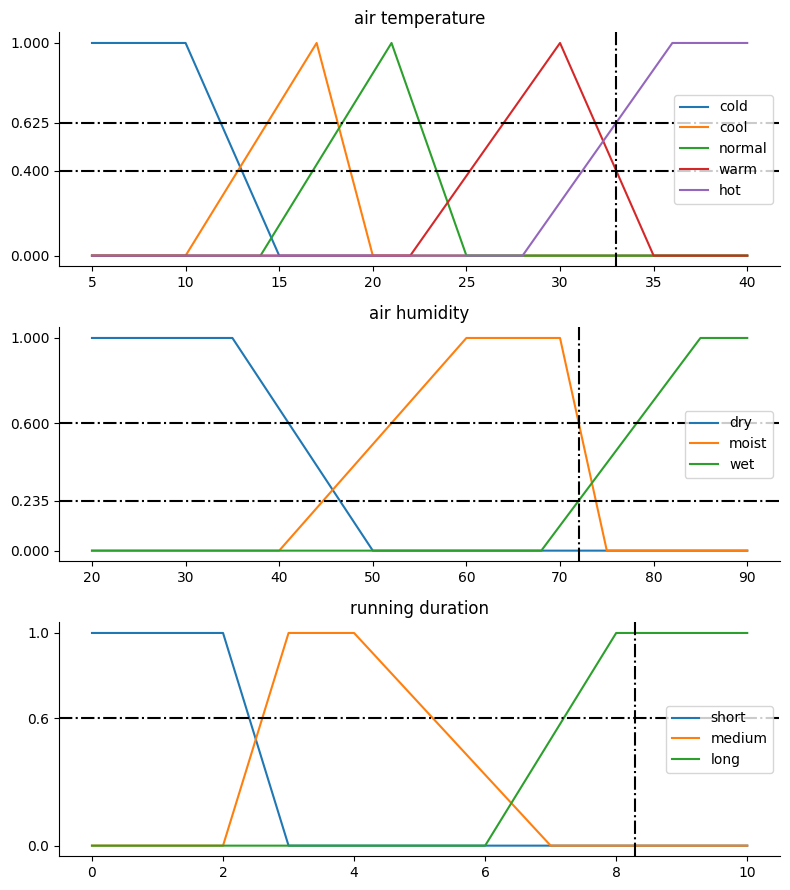

In [706]:
# Visualize these universes and membership functions
fig,(figure1,figure2,figure3)=plt.subplots(nrows=3,figsize=(8,9))
# color_matrix = ['r', 'g', 'b', 'y', 'pink'] # 可以不需要，matplotlib會隨機生成顏色
# figure1 is x_temp 
## Plot membership function
for i, key in enumerate(x_temp.terms):
  x_temp_cold_value = fuzz.interp_membership(x_temp_range, x_temp[key].mf, x_temp_range) # 取出某一個fuzzy set 的數值
  # figure1.plot(x_temp_range,x_temp_cold_value,color_matrix[i],linewidth=1.5,label=key) # 指定顏色，需要用到color_matrix
  figure1.plot(x_temp_range,x_temp_cold_value,linewidth=1.5,label=key)

## Plot the input and the grade
figure1.axvline(x=input_temp, color='k', linestyle='-.')
yticks_temp=[0, 1]
for key in temp_membership_grade:
  if temp_membership_grade[key] != 0:
    figure1.axhline(y=temp_membership_grade[key], color='k', linestyle='-.')
    yticks_temp.append(temp_membership_grade[key])
figure1.set_yticks(yticks_temp)

figure1.set_title('air temperature')
figure1.legend()

# figure2 is x_humi
## Plot membership function
for i, key in enumerate(x_humi.terms):
  x_humi_cold_value = fuzz.interp_membership(x_humi_range, x_humi[key].mf, x_humi_range) # 取出某一個fuzzy set 的數值
  figure2.plot(x_humi_range,x_humi_cold_value,linewidth=1.5,label=key)

## Plot the input and the grade
figure2.axvline(x=input_humi, color='k', linestyle='-.')
yticks_humi=[0, 1]
for key in humi_membership_grade:
  if humi_membership_grade[key] != 0:
    figure2.axhline(y=humi_membership_grade[key], color='k', linestyle='-.')
    yticks_humi.append(humi_membership_grade[key])
figure2.set_yticks(yticks_humi)
figure2.set_title('air humidity')
figure2.legend()

# figure 3 is y_time
## Plot membership function
for i, key in enumerate(y_time.terms):
  y_time_cold_value = fuzz.interp_membership(y_time_range, y_time[key].mf, y_time_range) # 取出某一個fuzzy set 的數值
  figure3.plot(y_time_range,y_time_cold_value,linewidth=1.5,label=key)

## Plot the input and the grade
figure3.axvline(x=out_y, color='k', linestyle='-.')
yticks_time=[0, 1]
for key in time_membership_grade:
  if time_membership_grade[key] != 0:
    figure3.axhline(y=time_membership_grade[key], color='k', linestyle='-.')
    yticks_time.append(time_membership_grade[key])
figure3.set_yticks(yticks_time)
figure3.set_title('running duration')
figure3.legend()

# plot 2d figures
for fi in (figure1,figure2,figure3):
  fi.spines['top'].set_visible(False)
  fi.spines['right'].set_visible(False)
  fi.get_xaxis().tick_bottom()
  fi.get_yaxis().tick_left()

plt.tight_layout()

# 3D figure


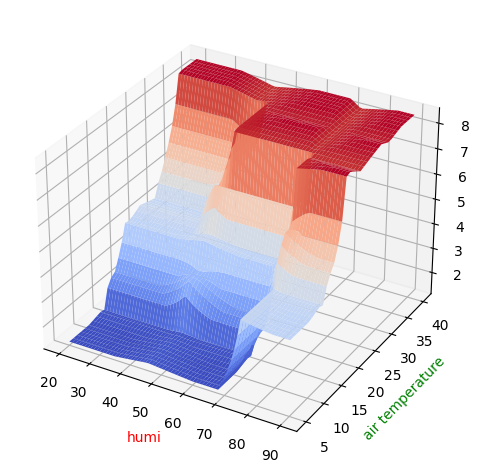

In [707]:
def funz(x, y):
  sys_sim.input["temp"] = y
  sys_sim.input["humi"] = x 
  sys_sim.compute()
  z=sys_sim.output["time"]
  return z

fig1 = plt.figure() # 建立一個繪圖物件
ax = Axes3D(fig1) # 用這個繪圖物件建立一個Axes物件(有3D座標) ### localhost 無法單用這一行顯示圖片
ax = fig1.add_subplot(111, projection='3d') ### 設為一個子圖來顯示


X, Y = np.meshgrid(x_humi_range,x_temp_range)
Z = funz(X, Y)
ax.plot_surface(X, Y, Z, rstride=1,cstride=1,cmap=plt.cm.coolwarm)#用取樣點(x,y,z)去構建曲面
ax.set_xlabel('humi', color='r')
ax.set_ylabel('air temperature', color='g')
ax.set_zlabel('running', color='b')#給三個座標軸註明
plt.tight_layout() # 顯示所有axis-label避免被裁切
# plt.show()#顯示模組中的所有繪圖物件
